In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/Embedded

/content/drive/My Drive/Embedded


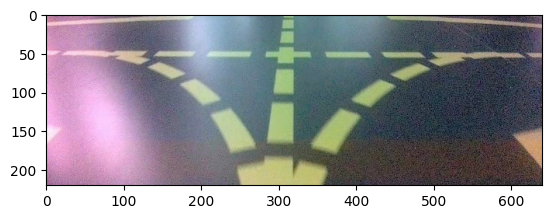

In [4]:
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('./dataset/images_new_straight/frame_000000027.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = image[140:,:]

plt.imshow(image)

In [2]:
import numpy as np
import os
import PIL.Image
import cv2

import torch
import torch.utils.data
import torchvision.transforms as transforms

TRAIN_TRANSFORMS = transforms.Compose([
    # transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

TEST_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


class CenterDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, random_hflip=True, transform=TRAIN_TRANSFORMS):
        super(CenterDataset, self).__init__()
        self.root_dir = root_dir
        self.random_hflip = random_hflip
        self.transform = transform

        with open(os.path.join(root_dir, 'annotation_109109_left.txt'), 'r') as f:
            self.data = [line.split() for line in f.readlines()]
            # self.data = [(image_filename: (xpos, ypos) for image_filename, xpos, ypos in f.readlines()}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename, xpos, ypos = self.data[idx]
        xpos = int(xpos)
        ypos = int(ypos)

        #image = PIL.Image.open(filename)
        image = cv2.imread(filename, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image[140:,:]

        image = PIL.Image.fromarray(image)
        width = image.width
        height = image.height

        # image = cv2.imread(filename, cv2.IMREAD_COLOR)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # height, width = image.shape[:2]

        # image = PIL.Image.fromarray(image)
        # width = image.width
        # height = image.height
        if self.transform is not None:
            image = self.transform(image)

        x = 2.0 * (xpos / width - 0.5) # map to [-1, +1]
        y = 2.0 * ((ypos - 140) / height - 0.5) # map to [-1, +1]

        if self.random_hflip and float(np.random.random(1)) > 0.5:
            image = torch.flip(image, [-1])
            x = -x

        return image, torch.Tensor([x, y])


In [8]:
import torch
import torchvision
# import ipywidgets
import torch.nn.functional as f

def get_model():
    model = torchvision.models.alexnet(num_classes=2, dropout=0.0)
    return model

device = torch.device('cuda')
model = get_model()
model.load_state_dict(torch.load('road_model_109109_left.pth'))
model = model.to(device)


batch_size = 16

dataset = CenterDataset('dataset', random_hflip=False)
train_loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
)

epoch = 5
#learning_rate = 2e-3
learning_rate = 2e-5

'''
epoch_slider = ipywidgets.IntSlider(description='Epochs', value=epoch, min=1, max=200, step=1)
lr_slider = ipywidgets.FloatSlider(description='lr', value=learning_rate, min=1e-4, max=1e-2, step=1e-4, readout_format='.4f')
train_button = ipywidgets.Button(description='Train', icon='tasks')
loss_text = ipywidgets.Textarea(description='Progress', value='', rows=15, layout=ipywidgets.Layout(width="50%", height="auto"))
layout = ipywidgets.VBox([ipywidgets.HBox([epoch_slider, lr_slider, train_button]), loss_text])
'''

def train_model():
    global epoch
    for e in range(epoch):
        #loss_text.value += "<<<<< Epoch {:d} >>>>>\n".format(epoch)
        print("epoch:", e)
        train_step(e)


def train_step(epoch):
    global model, device

    try:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        # optimizer = torch.optim.SGD(model.parameters(), lr=lr_slider.value, momentum=0.9)

        #train_button.disabled = True
        model = model.train()

        num_iters = len(train_loader)
        for ii, (images, labels) in enumerate(train_loader):
            # send data to device
            images = images.to(device)
            labels = labels.to(device)

            # zero gradients of parameters
            optimizer.zero_grad()

            # execute model to get outputs
            outputs = model(images)

            # compute MSE loss over x coordinates
            loss = f.mse_loss(outputs, labels, reduction='sum')

            # run backpropogation to accumulate gradients
            loss.backward()

            # step optimizer to adjust parameters
            optimizer.step()

            if ii % 10 == 0:
                xlbl, ylbl = labels[0].cpu()
                xlbl = ( xlbl.item() / 2 + 0.5 ) * 640
                ylbl = ( ylbl.item() / 2 + 0.5 ) * 220

                xpre, ypre = outputs[0].cpu()
                xpre = ( xpre.item() / 2 + 0.5 ) * 640
                ypre = ( ypre.item() / 2 + 0.5 ) * 220
                '''
                msg = "[{:04d} / {:04d}] loss: {:.4f} | labels: ({:.2f}, {:.2f}), outpus: ({:.2f}, {:.2f})\n".format(ii, num_iters, loss.item(), xlbl, ylbl, xpre, ypre)
                loss_text.value += msg
                '''
                print(ii,'/',num_iters,'    loss:',loss.item())

            #model = model.eval()
            #torch.save(model.state_dict(), 'road_model_new_left_epoch%d.pth'%epoch)

    except Exception as e:
        print(e)
        pass

    model.eval()
    torch.save(model.state_dict(), 'road_model_109109109_left.pth')
    # train_button.disabled = False

# train_button.on_click(train_model)
train_model()
# display(layout)

model = get_model()
model = model.to(device)

# from torch2trt import TRTModule
# model = TRTModule()
# model.load_state_dict(torch.load('road_following_model.pth'))

epoch: 0
0 / 9     loss: 23.788875579833984
epoch: 1
0 / 9     loss: 20.82793426513672
epoch: 2
0 / 9     loss: 7.479545593261719
epoch: 3
0 / 9     loss: 14.321945190429688
epoch: 4
0 / 9     loss: 12.283432006835938
epoch: 5
0 / 9     loss: 3.197956085205078
epoch: 6
0 / 9     loss: 4.577470779418945
epoch: 7
0 / 9     loss: 3.155500888824463
epoch: 8
0 / 9     loss: 7.064091205596924
epoch: 9
0 / 9     loss: 2.0814552307128906
epoch: 10
0 / 9     loss: 4.385517597198486
epoch: 11
0 / 9     loss: 3.9593443870544434
epoch: 12
0 / 9     loss: 1.9292263984680176
epoch: 13
0 / 9     loss: 2.4486472606658936
epoch: 14
0 / 9     loss: 1.1383041143417358
epoch: 15
0 / 9     loss: 0.2543097734451294
epoch: 16
0 / 9     loss: 0.7984508275985718
epoch: 17
0 / 9     loss: 1.1357421875
epoch: 18
0 / 9     loss: 0.810253918170929
epoch: 19
0 / 9     loss: 0.7344896793365479
epoch: 20
0 / 9     loss: 0.4182618260383606
epoch: 21
0 / 9     loss: 0.36846309900283813
epoch: 22
0 / 9     loss: 0.98736